## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2023.

# ECBM E4040 - Assignment 2 - Task 3: Convolutional Neural Network (CNN)

In this task, you are going to first practice the forward/backward propagation of the convolution operations with NumPy. After that, we will introduce TensorFlow with which you will create your CNN model for an image classification task.

## CNNs

Convolutional neural networks (CNNs) are highly effective for image processing tasks. 

When one builds a MLP model, each connection is multiplied by its own weight. When the input dimension or the first layer is very large, we need a giant matrix to store the weights. This could easily become a problem in image processing since the dimension of a vectorized image could easily exceed 1000 (consider CIFAR-10 which has images of shape 32×32=1024, yet the resolution is so low). 

In CNN, the weights are shared: the same filter (also known as 'weights' or 'kernel') moves over the input, and at each position an output value is calculated. This means that the same weights are repetitively applied to the entire input, therefore saving a lot of memory.

![Illustration of the CNN](./utils/notebook_images/task3_1.jpg)

[Image source](https://developer.apple.com/library/content/documentation/Performance/Conceptual/vImage/ConvolutionOperations/ConvolutionOperations.html)

__Convolution:__  In the picture above, the input is a 7-by-7 image, and the filter is shown as a blue 3-by-3 grid. The filter overlaps with the top-left corner of the input, and we perform an element-wise multiplication followed by a summation, then put the sum into the output matrix. The filter then moves several pixels right, covering a new input area so a new sum can be derived.

__Training:__ One thing to remember is that there would be a lot of filters for each layer in a CNN, and the goal of training is to find the best filters for your task. Each filter tries to capture one specific feature. Typically, in the first convolutional layer which directly looks at your input, the filters try to capture information about color and edges which we know as local features; in higher layers, due to the effect of max-pooling, the receptive-fields of filters becomes large so more global and complex features can be detected. 

__Architecture:__ For classification tasks, a CNN usually starts with convolution commonly followed by either average-pooling or max-pooling. After that, the feature maps will be flattened so that we could append fully connected layers. Common activation functions include ReLu, ELU in the convolution layers, and softmax in the fully connected layers (to calculate the classification scores).

### Terminology

* __Convolution__: element-wise multiplication followed by summation of your input and one of your filters in the CNN context.
* __Filter/kernel/weights__: a grid or a set of grids typically smaller than your input size that moves over the input space to generate output. Each filter captures one type of feature.
* __Feature/feature maps__: the output of a hidden layer. Think of it as another representation of your data. 
* __Pooling__: a downsampling operation that joins local information together, so the higher layers' receptive fields can be bigger. The most seen pooling operation is max-pooling, which outputs the maximum of all values inside the pool.
* __Flatten__: a junction between convolution layers and fully connected layers. Used to turn 2-D feature maps into 1-D. For tasks such as image segmentation where the output also needs to be 2-D, this won't be used.
* __Border mode__: usually refers to 'VALID' or 'SAME'. Under 'VALID' mode, only when the filter and the input fully overlap can a convolution be conducted; under 'SAME' mode, the output size is the same as the input size (only when the stride is 1), and when the filter and the input don't fully overlap (happens at the edge/corner of input) we pad zeroes (or other designated numbers) and then do convolution.

[This site](https://cs231n.github.io/convolutional-networks/) is also a good reference.

In [1]:
import numpy as np
import tensorflow as tf

%load_ext autoreload
%autoreload 2

In [2]:
print(tf.__version__)

2.4.0


In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
!nvidia-smi

Wed Oct 25 21:39:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    28W /  70W |    248MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Part 1: Understanding Convolution (15%)

### conv2d feedforward

Implement a NumPy naive 2-D convolution feedforward function. We ask you to simply do the element-wise multiplication and summation. Do not worry about the efficiency of your functions. Use as many loops as you like.

<span style="color:red">__TODO:__</span> Complete the function __conv2d_forward__ in __utils/layer_funcs.py__. After that, run the following cell blocks in Jupyter notebook, which will give the output of your convolution function. Detailed instructions have been given in the comments of __layer_func.py__. __The instructors will look at the output to give credits for this task__.

In [7]:
# tf 2.4.0 implementation
from utils.layer_funcs import conv2d_forward

# Set test parameters.
x_shape = (2, 7, 7, 3) #(batch, height, width, channels)
w_shape = (3, 3, 3, 4) #(filter_height, filter_width, channels, num_of_filters)
channels = w_shape[-1]

#Superficial change
x = np.linspace(-0.5, 0.1, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.3, 0.2, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.2, 0.3, num=channels)

pad = 1
stride = 3
your_feedforward = conv2d_forward(x, w, b, pad, stride)

print("Your feedforward result (size :{}) is: ".format(your_feedforward.shape))
print(your_feedforward)

Your feedforward result (size :(2, 3, 3, 4)) is: 
[[[[-0.49018405 -0.35006199 -0.20993993 -0.06981787]
   [-0.38629836 -0.25815678 -0.1300152  -0.00187362]
   [-0.17199324 -0.03014875  0.11169575  0.25354024]]

  [[ 0.07961979  0.21551232  0.35140485  0.48729737]
   [ 0.47663201  0.5990752   0.7215184   0.8439616 ]
   [ 0.40188702  0.5403632   0.67883938  0.81731556]]

  [[ 0.17364167  0.32582076  0.47799985  0.63017894]
   [ 0.45442123  0.60064836  0.74687549  0.89310261]
   [ 0.28514051  0.43904203  0.59294355  0.74684508]]]


 [[[-0.29100188 -0.13399998  0.02300192  0.18000383]
   [-0.23944372 -0.08598237  0.06747897  0.22094032]
   [-0.17536921 -0.01664487  0.14207947  0.3008038 ]]

  [[-0.07736276  0.08384953  0.24506183  0.40627412]
   [ 0.01328028  0.17370312  0.33412597  0.49454882]
   [-0.05893273  0.10486322  0.26865916  0.43245511]]

  [[-0.23485056 -0.06579163  0.10326731  0.27232624]
   [-0.31023572 -0.13868882  0.03285807  0.20440496]
   [-0.32590986 -0.15512849  0.015652

In [8]:
######################################################
# Verification/checking code. Do not modify it       #
######################################################

X_tf = tf.constant(x, shape=x_shape)
w_tf = tf.constant(w, shape=w_shape)
b_tf = tf.constant(b, shape=channels)

def conv2d_forward_tf(x, w, b, stride):
    # stride in tf.nn.conv2d is in the format: [1, x_movement, y_movement, 1]
    feedforward = tf.nn.conv2d(x, w, [1, stride, stride, 1], padding="SAME")
    # add bias to the conv network
    feedforward = tf.nn.bias_add(feedforward, b)
    return feedforward

print("Is your feedforward correct? {}".format(np.allclose(
    your_feedforward, conv2d_forward_tf(X_tf, w_tf, b_tf, stride)
)))

Is your feedforward correct? True


### Backpropagation (Demo) for 2D Convolution

**This function is a demo for NumPy naive 2-D convolution backpropagation.**

Implementations could be found in the function __conv2d_backward__ in __utils/layer_funcs.py__. Run the following cell blocks, which will give the output of your backpropagation. No need to change them.

In [9]:
####################################################
# Demo code. Don't change it.                      #
####################################################
from utils.layer_funcs import conv2d_backward
# Set test parameters. Please don't change it.
np.random.seed(123)
d_top = np.random.normal(size=your_feedforward.shape)
your_dw, your_db, d_w_shape = conv2d_backward(d_top, x, w, b, pad, stride)

print("Your weights' gradients result (size :{}) is: ".format(d_w_shape))
print(your_dw)
print("Your biases' gradients result is: ")
print(your_db)

Your weights' gradients result (size :(3, 3, 3, 4)) is: 
[[[[-0.9448206  -1.0686526  -0.3135852  -0.03957435]
   [-0.93686473 -1.0602988  -0.30789375 -0.04026189]
   [-0.9289089  -1.0519449  -0.3022023  -0.04094943]]

  [[-1.3040056  -0.8374328  -0.21998174  0.6414077 ]
   [-1.2951415  -0.8254823  -0.21534838  0.63206196]
   [-1.2862774  -0.8135318  -0.21071501  0.62271625]]

  [[-1.2994598  -0.3068896  -0.25185415  1.1314708 ]
   [-1.287848   -0.3005608  -0.25122565  1.1195849 ]
   [-1.2762363  -0.294232   -0.25059715  1.107699  ]]]


 [[[-0.99625653 -0.9673741   0.9784877   0.02301925]
   [-0.987849   -0.96097547  0.98191816  0.02328004]
   [-0.97944146 -0.95457685  0.98534864  0.02354082]]

  [[-0.79276395 -1.3021034   1.0766063   1.2217364 ]
   [-0.7856655  -1.2886565   1.0777571   1.2108353 ]
   [-0.778567   -1.2752095   1.0789078   1.1999341 ]]

  [[-0.10447567 -1.2830693   1.0130789   1.6749119 ]
   [-0.09791528 -1.2734449   1.006716    1.6608189 ]
   [-0.09135488 -1.2638205   1

In [10]:
####################################################
# Verification/checking code. Don't change it.     #
####################################################
d_top_tf = tf.constant(d_top, shape=your_feedforward.shape)
def conv2d_backward_tf(x, w, b, d, stride):
    # stride in tf implementation is in the format: [1, x_movement, y_movement, 1]

    dw_tf =  tf.compat.v1.nn.conv2d_backprop_filter(x, w, d, [1, stride, stride, 1], padding = "SAME")
    with tf.GradientTape() as g:
        g.watch(b)
        y = conv2d_forward_tf(X_tf, w_tf, b, stride) * d
    dy_dx = g.gradient(y, b)
    return dw_tf, dy_dx

print("Are your weights' gradients correct? {}".format(np.allclose(
    your_dw, conv2d_backward_tf(X_tf, w_shape, b_tf, d_top_tf, stride)[0])
))
print("Are your biases' gradients correct? {}".format(np.allclose(
    your_db, conv2d_backward_tf(X_tf, w_shape, b_tf, d_top_tf, stride)[1])
))

Are your weights' gradients correct? True
Are your biases' gradients correct? True


### MaxPool Feedforward

Implement a NumPy naive max pool feedforward function. We ask you to simply find the maximum value in your pooling window. Also, don't need to worry about the efficiency of your function. Use loops as many as you like.

<span style="color:red">__TODO:__</span> Finish the function __max_pool_forward__ in __utils/layer_funcs.py__. After that, run the following cell blocks, which will give the output of your max pool function. Detailed instructions have been given in the comments of __layer_func.py__. __We need to judge your output to give you credits__.

In [12]:
from utils.layer_funcs import max_pool_forward

# Set test parameters.
x_shape = (2, 7, 7, 3) #(batch, height, width, channels)
x = np.linspace(-0.5, 0.5, num=np.prod(x_shape)).reshape(x_shape)
print(x[0,:,:,0])

pool_size = 2
stride = 3

your_feedforward = max_pool_forward(x, pool_size, stride)

print(your_feedforward[0,:,:,0])
print("Your feedforward result size :{}".format(your_feedforward.shape))


[[-0.5        -0.48976109 -0.47952218 -0.46928328 -0.45904437 -0.44880546
  -0.43856655]
 [-0.42832765 -0.41808874 -0.40784983 -0.39761092 -0.38737201 -0.37713311
  -0.3668942 ]
 [-0.35665529 -0.34641638 -0.33617747 -0.32593857 -0.31569966 -0.30546075
  -0.29522184]
 [-0.28498294 -0.27474403 -0.26450512 -0.25426621 -0.2440273  -0.2337884
  -0.22354949]
 [-0.21331058 -0.20307167 -0.19283276 -0.18259386 -0.17235495 -0.16211604
  -0.15187713]
 [-0.14163823 -0.13139932 -0.12116041 -0.1109215  -0.10068259 -0.09044369
  -0.08020478]
 [-0.06996587 -0.05972696 -0.04948805 -0.03924915 -0.02901024 -0.01877133
  -0.00853242]]
[[-0.41808874 -0.38737201]
 [-0.20307167 -0.17235495]]
Your feedforward result size :(2, 2, 2, 3)


In [13]:
####################################################
# Verification/checking code. Don't change it.     #
####################################################
X_tf = tf.constant(x, shape=x_shape)

def maxpool_forward_2(x, pool_size, stride):
    maxpool_forward = tf.nn.max_pool(x, [1, pool_size, pool_size, 1], [1, stride, stride, 1], padding='VALID')
    return maxpool_forward

## Print validation result
print(maxpool_forward_2(X_tf, pool_size, stride)[0,:,:,0])
print("Is your feedforward correct? {}".format(np.allclose(your_feedforward, maxpool_forward_2(X_tf, pool_size, stride))))

tf.Tensor(
[[-0.41808874 -0.38737201]
 [-0.20307167 -0.17235495]], shape=(2, 2), dtype=float64)
Is your feedforward correct? True


### Max pool backpropagation

Implement a Numpy naive max pooling backpropagation function, referring to the conv2d backpropagation demo. Again, don't worry about the efficiency.

<span style="color:red">__TODO:__</span> Finish the function __max_pool_backward__ in __utils/layer_funcs.py__. After that, run the following cell blocks, which will give the output of your backpropagation. Detailed instructions have been given in the comments of __layer_func.py__. __We need to judge your output to give you credits__.

In [14]:
from utils.layer_funcs import max_pool_backward

# Set test parameters. Please don't change it.
np.random.seed(123)
dout = np.random.normal(size=your_feedforward.shape)
dx = max_pool_backward(dout, x, pool_size, stride)

print("Your inputs' gradients result (size :{}) is: ".format(dx.shape))
print(dx[0,:,:,0])

Your inputs' gradients result (size :(2, 7, 7, 3)) is: 
[[ 0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.         -1.0856306   0.          0.         -1.50629471  0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.         -2.42667924  0.          0.         -0.8667404   0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.        ]]


In [15]:
#######################################
# Checking code. Don't change it.     #
#######################################
d_out_tf = tf.constant(dout, shape=your_feedforward.shape)

def max_pool_backward_2(x, d):
    with tf.GradientTape() as g:
        g.watch(x)
        y = maxpool_forward_2(X_tf, pool_size, stride) * d
    dy_dx = g.gradient(y, x)
    return dy_dx
# ## Print validation result
print(max_pool_backward_2(X_tf, d_out_tf)[0,:,:,0])
print("Is your inputs' gradients correct? {}".format(np.allclose(dx, max_pool_backward_2(X_tf, d_out_tf))))

tf.Tensor(
[[ 0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.         -1.0856306   0.          0.         -1.50629471  0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.         -2.42667924  0.          0.         -0.8667404   0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.        ]], shape=(7, 7), dtype=float64)
Is your inputs' gradients correct? True


## Part 2: TensorFlow CNN (15%)

In this part we will construct the CNN in TensorFlow. We will implement a CNN similar to the LeNet structure.

TensorFlow offers many useful resources and functions which help developers build the net in a high-level fashion, such as functions in the `layer` module. By utilizing functions in `tf.keras` that exist for Neural Network structuring and training, we can build our own layers and network modules rather quickly.

Also, we will introduce a visualization tool called Tensorboard. You can use Tensorboard to visualize your TensorFlow graph, plot quantitative metrics about the execution of your graph, and show additional data that passes through it.

Resources and References: <br>
* [TensorBoard: Visualizing Learning](https://www.tensorflow.org/get_started/summaries_and_tensorboard)<br>
* [Convolutional Neural Networks (LeNet) - DeepLearning 0.1 documentation](http://deeplearning.net/tutorial/lenet.html)<br>
* [LeNet-5, convolutional neural networks](http://yann.lecun.com/exdb/lenet/)

### Quick guide for Tensorboard

Tensorboard is a powerful tool provided by TensorFlow. It allows developers to check their graph and trend of parameters. This guide will give you a basic understanding on how to initiate the Tensorboard Jupyter Notebook extension and how to understand the results of the training of your model.

For more information, check the official guide on Tensorflow web site [here](https://www.tensorflow.org/get_started/summaries_and_tensorboard).

### How to start Tensorboard

The cell at the bottom of the Jupyter Notebook should be executed once the model has been trained. In the TensorBoard notebook extension, you will be able to see the training/validation accuracies and loss graphs associated with each model fit. The most recent results can be filtered in the bottom-left hand corner by selecting the most recent training and validation results at the bottom of the list.

### Check the graph and summary in Tensorboard

After executing the cell once, you should able to see the metrics displayed in the tensorboard. 

![Tensorboard_2](./utils/notebook_images/Task3_2_2_metrics.png)


Also, you may be able to zoom in or zoom out or click into the layer block to check all the variables and tensor operations in the graph, check the trend of the variables and the distribution of those in Scalar, Distributions and Histograms. You may explore the tensorboard by yourself and take advantage to it for debugging the network structure.

<span style="color:red">__TODO:__</span> You will try to achieve your own CNN model below that has similar structure to LeNet, show the model graph in tensorboard, and get a model with __90% or higher accuracy__ using the data we provide you. You will use the Keras API to build your model.

There is example code for a simplified LeNet model in __utils/neuralnets/cnn/model_LeNet.py__. This sample is used as a guide line for how to build a Neural Net model in Tensorflow using Keras functions. Feel free to study the code and use it to build your own CNN below.

<span style="color:red">__TODO:__</span>
1. Edit the TODO cell below for the **create_model()** function. Create your own CNN that is based on the LeNet structure to achieve at least **90% test accuracy.**
2. Print out the training process and the best validation accuracy, save the model in __model/__ folder.
3. Attach a screenshot of your tensorboard graph in the markdown cell below. Double click the cell and replace the example image with your own image. Here is a [Markdown Cheetsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#images) that may also help.

__Hint__: You may add/modify layers to your CNN to achieve 90% test accuracy.

### Sequential implementation.

In [16]:
import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
import datetime

In [17]:
#Load data from the Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

<span style="color:red">__TODO:__</span>
Modify the __create_model()__ function to return a model that can achieve **90% or higher validation accuracy**. For more information on the Keras API, please see https://www.tensorflow.org/api_docs/python/tf/keras.

In [26]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')  
    ])
    
    return model

In [27]:
#Create the model, compile the model, and fit it
model_test = create_model()
model_test.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model_test.fit(x=x_train, 
          y=y_train,
          batch_size=256,
          epochs=10, 
          validation_data=(x_test, y_test), 
          callbacks=[tensorboard_callback])

Epoch 1/10
235/235 [==============================] - 14s 57ms/step - loss: 0.7379 - accuracy: 0.7273 - val_loss: 0.4423 - val_accuracy: 0.8378
Epoch 2/10
235/235 [==============================] - 14s 60ms/step - loss: 0.4312 - accuracy: 0.8424 - val_loss: 0.3577 - val_accuracy: 0.8661
Epoch 3/10
235/235 [==============================] - 14s 60ms/step - loss: 0.3685 - accuracy: 0.8647 - val_loss: 0.3224 - val_accuracy: 0.8797
Epoch 4/10
235/235 [==============================] - 15s 62ms/step - loss: 0.3332 - accuracy: 0.8759 - val_loss: 0.2938 - val_accuracy: 0.8909
Epoch 5/10
235/235 [==============================] - 14s 61ms/step - loss: 0.3084 - accuracy: 0.8863 - val_loss: 0.2837 - val_accuracy: 0.8913
Epoch 6/10
235/235 [==============================] - 14s 60ms/step - loss: 0.2880 - accuracy: 0.8927 - val_loss: 0.2695 - val_accuracy: 0.8988
Epoch 7/10
235/235 [==============================] - 14s 61ms/step - loss: 0.2744 - accuracy: 0.8994 - val_loss: 0.2580 - val_accuracy:

<span style="color:red">__TODO:__</span>
Save the best performing model to the **model/** directory using the code below.

In [28]:
model_test.save(filepath="./model/task3_model")

INFO:tensorflow:Assets written to: ./model/task3_model/assets


INFO:tensorflow:Assets written to: ./model/task3_model/assets


**For future reference, a model can be loaded using load_model() on the file path containing your saved model:**

In [29]:
loaded_model = tf.keras.models.load_model("./model/task3_model")
print(loaded_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 7, 7, 64)         

<span style="color:red">__TODO:__</span>
Generate the TensorBoard notebook extension and attach a screenshot of the train/test accuracy and loss graphs below the Solution cell.

In [30]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir logs/fit --bind_all

**Solution:**
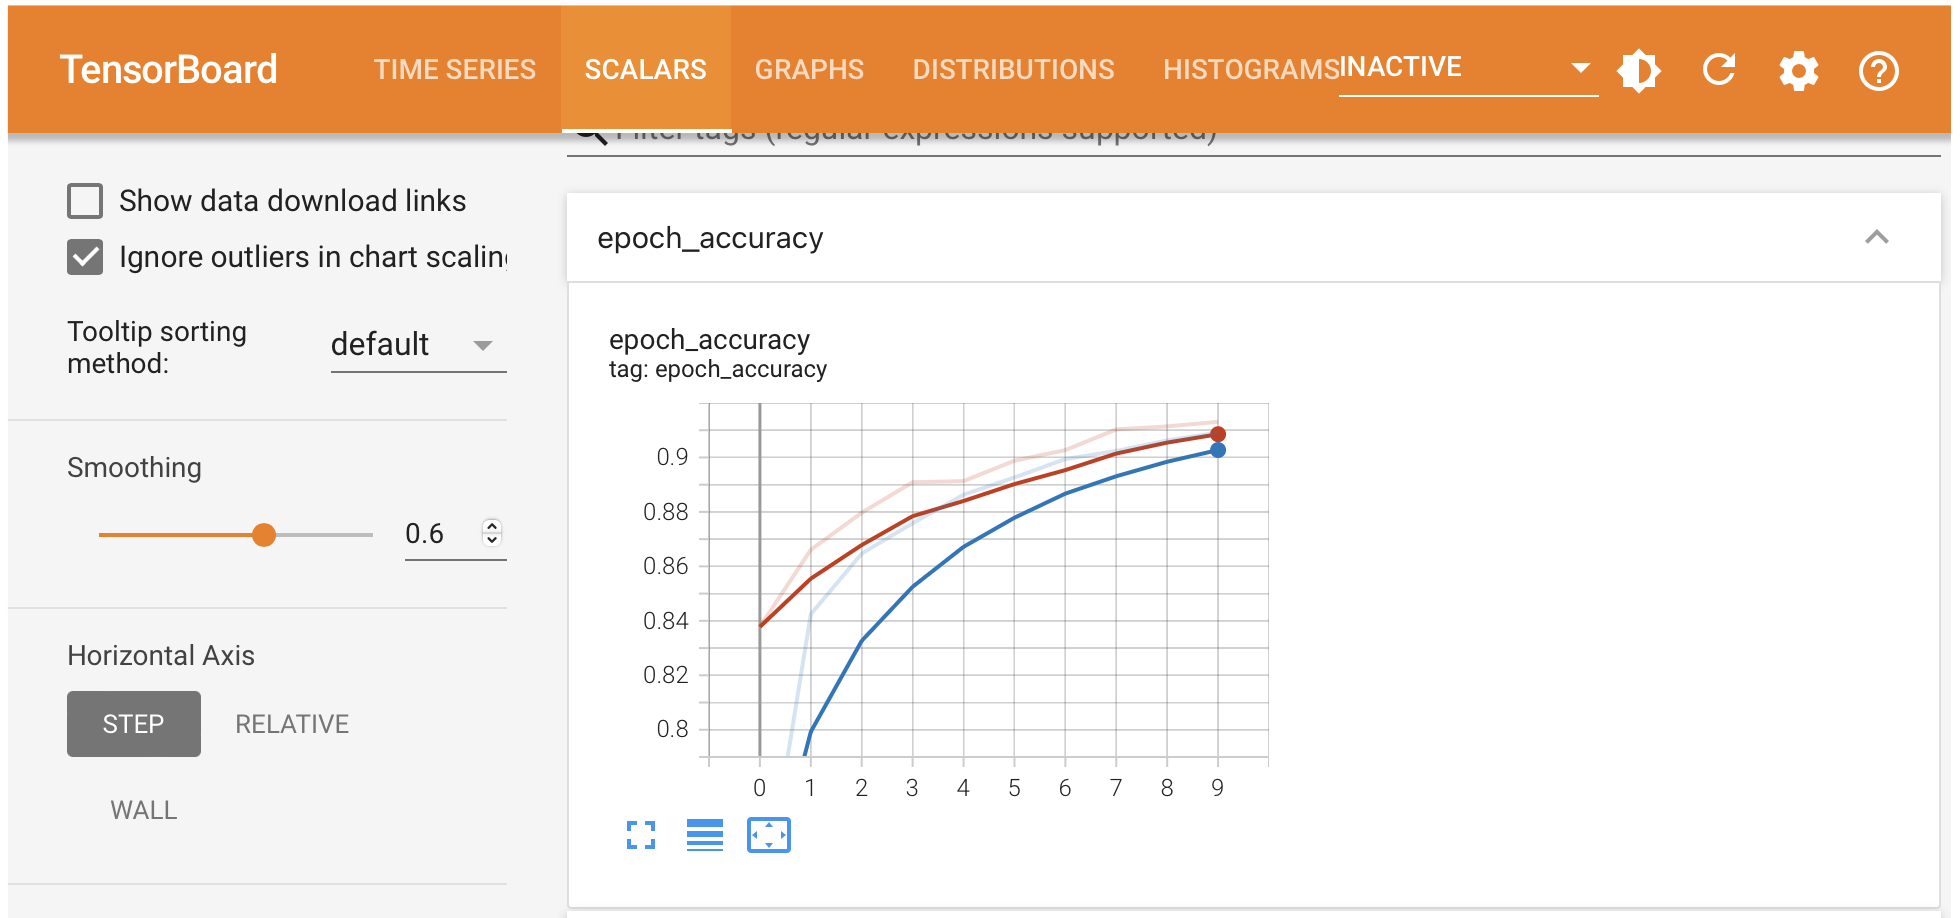
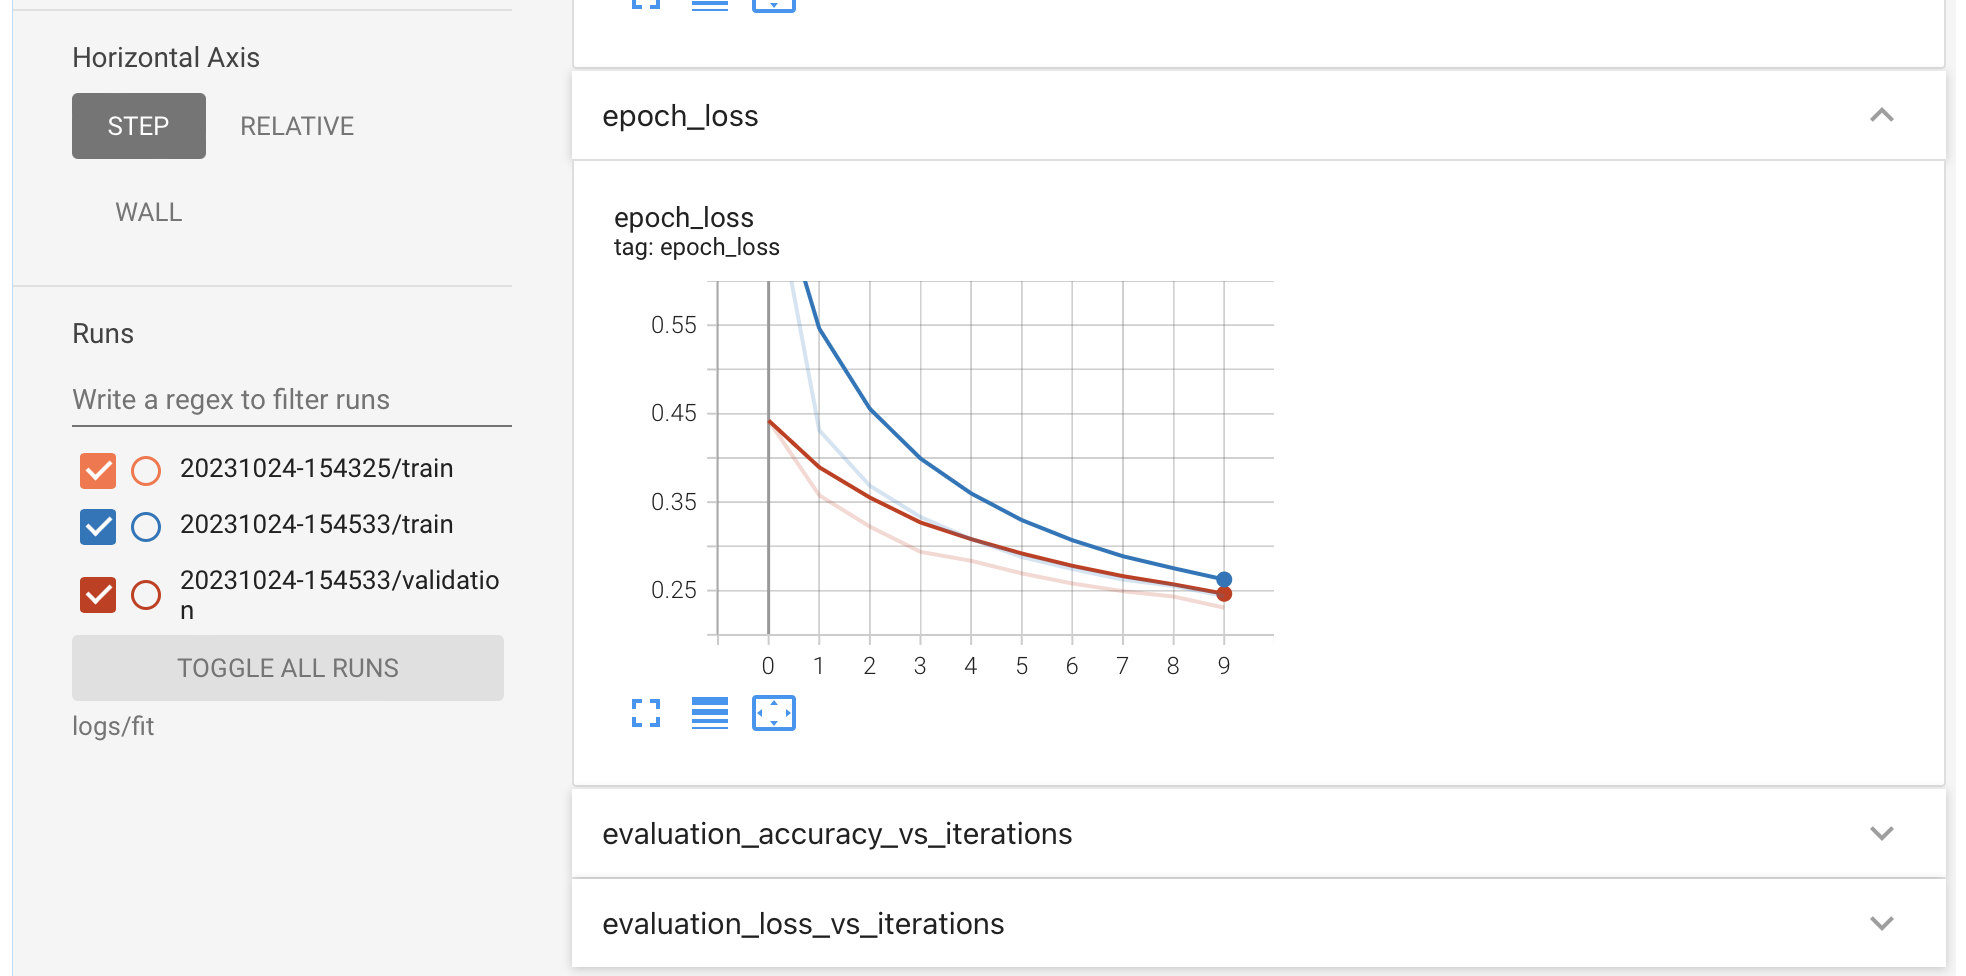